# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation
import nltk
from nltk.corpus import stopwords

sw = stopwords.words("english")

In [31]:
# Add any additional import statements you need here
from nltk.tokenize import word_tokenize
import string
import emoji



In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/justinfarnan_hakkoda/ads_text_mining/M2/M1_Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
lyrics_data = pd.DataFrame(columns = ['artist', 'song', 'lyris'])

for artist in os.listdir(f'{data_location}/lyrics'):
    artist_folder = os.path.join(data_location, 'lyrics', artist)
    for song in os.listdir(artist_folder):
        song_file = os.path.join(artist_folder, song)
        with open(song_file, 'r') as file:
            lyrics = file.read()
            new_row = pd.DataFrame({'artist': [artist], 'song': [song], 'lyrics': [lyrics]})
            lyrics_data = pd.concat([lyrics_data, new_row], ignore_index=True)

In [5]:
lyrics_data.head()

,artist,song,lyris,lyrics
0,robyn,robyn_includemeout.txt,NaN,"""Include Me Out""\n\n\n\nIt is really very simp..."
1,robyn,robyn_electric.txt,NaN,"""Electric""\n\n\n\nElectric...\n\nIt's electric..."
2,robyn,robyn_beach2k20.txt,NaN,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow..."
3,robyn,robyn_lovekills.txt,NaN,"""Love Kills""\n\n\n\nIf you're looking for love..."
4,robyn,robyn_timemachine.txt,NaN,"""Time Machine""\n\n\n\nHey, what did I do?\nCan..."


In [6]:
# Read in the twitter data
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)
twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [7]:
# Read in the positive and negative words and the
# Define the file path
import pandas as pd

# Define file paths for positive, negative, and tidytext sentiment words
negative_file_path = 'negative-words.txt'
positive_file_path = 'positive-words.txt'
tidytext_file_path = 'tidytext_sentiments.txt'

# Initialize lists to store words and their sentiment scores
words = []
scores = []

def read_words(file_path):
    words = []
    with open(file_path, 'r') as file:
        for line in file:
            # Strip whitespace from the line
            line = line.strip()
            # Ignore comments and empty lines
            if line and not line.startswith(';'):
                # Add the word to the list
                words.append(line)
    return words
negative_words = read_words(negative_file_path)
words.extend(negative_words)
scores.extend([-1] * len(negative_words))

# Read positive words and assign a score of +1
positive_words = read_words(positive_file_path)
words.extend(positive_words)
scores.extend([1] * len(positive_words))

tidytext = pd.read_csv("/Users/justinfarnan_hakkoda/ads_text_mining/M6/ads_sentiment_509/tidytext_sentiments.txt",
                       sep = "\t",
                       quoting=3)
# Extract words and their sentiment from the tidytext dataframe
tidytext_words = tidytext['word'].tolist()
tidytext_sentiments = tidytext['sentiment'].tolist()

# Assign scores based on the sentiment column
for word, sentiment in zip(tidytext_words, tidytext_sentiments):
    words.append(word)
    if sentiment == 'positive':
        scores.append(1)
    elif sentiment == 'negative':
        scores.append(-1)

# Create a dataframe to store the words and their scores
sentiment_df = pd.DataFrame({
    'word': words,
    'score': scores
})

# Print the dataframe
sentiment_df.tail()
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

,word,score
21917,win,1
21918,winner,1
21919,winners,1
21920,winning,1
21921,worthy,1


## Sentiment Analysis on Songs




In [8]:
# your code here
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    stop_words = stopwords.words('english')
    filtered_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    return filtered_tokens  # Return the list of tokens

lyrics_data['cleaned_lyrics'] = lyrics_data['lyrics'].apply(tokenize_and_remove_stopwords)


In [9]:
# Function to calculate sentiment score
def calculate_sentiment(tokens, lexicon):
    score = 0
    for token in tokens:
        score += lexicon.get(token, 0)
    return score

# Create a dictionary from the sentiment dataframe for quick lookup
lexicon = dict(zip(sentiment_df['word'], sentiment_df['score']))

# Calculate sentiment score for each song
lyrics_data['sentiment_score'] = lyrics_data['cleaned_lyrics'].apply(lambda tokens: calculate_sentiment(tokens, lexicon))

# Print the DataFrame to verify the result
lyrics_data

,artist,song,lyris,lyrics,cleaned_lyrics,sentiment_score
0,robyn,robyn_includemeout.txt,NaN,"""Include Me Out""\n\n\n\nIt is really very simp...","[include, really, simple, single, pulse, repea...",14
1,robyn,robyn_electric.txt,NaN,"""Electric""\n\n\n\nElectric...\n\nIt's electric...","[electric, electric, electric, natural, high, ...",23
2,robyn,robyn_beach2k20.txt,NaN,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow...","[beach, 2k20, wan, na, go, gon, na, get, ok, c...",21
3,robyn,robyn_lovekills.txt,NaN,"""Love Kills""\n\n\n\nIf you're looking for love...","[love, kills, looking, love, get, heart, made,...",-24
4,robyn,robyn_timemachine.txt,NaN,"""Time Machine""\n\n\n\nHey, what did I do?\nCan...","[time, machine, hey, ca, believe, fit, threw, ...",-5
...,...,...,...,...,...,...
415,cher,cher_takeitfromtheboys.txt,NaN,"""Take It From The Boys""\n\n\n\nSo scared I nev...","[take, boys, scared, never, hard, keep, good, ...",10
416,cher,cher_dreambaby.txt,NaN,"""Dream Baby""\n\n\n\nI found the boy for me\nHe...","[dream, baby, found, boy, dream, baby, almost,...",29
417,cher,cher_pleasedonttellme.txt,NaN,"""Please Don't Tell Me""\n\n\n\nYa shook the ove...","[please, tell, ya, shook, override, get, far, ...",-1
418,cher,cher_ihopeyoufindit.txt,NaN,"""I Hope You Find It""\n\n\n\nThese clouds aren'...","[hope, find, clouds, going, nowhere, darling, ...",10


In [10]:
# Analysis (example questions)
# Which artist has more positive songs?
positive_songs = lyrics_data[lyrics_data['sentiment_score'] > 0]
print("Positive songs:")
positive_songs.head()

Positive songs:


,artist,song,lyris,lyrics,cleaned_lyrics,sentiment_score
0,robyn,robyn_includemeout.txt,NaN,"""Include Me Out""\n\n\n\nIt is really very simp...","[include, really, simple, single, pulse, repea...",14
1,robyn,robyn_electric.txt,NaN,"""Electric""\n\n\n\nElectric...\n\nIt's electric...","[electric, electric, electric, natural, high, ...",23
2,robyn,robyn_beach2k20.txt,NaN,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow...","[beach, 2k20, wan, na, go, gon, na, get, ok, c...",21
6,robyn,robyn_givingyouback.txt,NaN,"""Giving You Back""\n\n\n\nIn another time\nAnot...","[giving, back, another, time, another, life, a...",20
7,robyn,robyn_noneofdem114527.txt,NaN,"""None Of Dem""\n\n\n\nNone of these boys can da...","[none, dem, none, boys, dance, single, one, st...",11


In [11]:
# Which artist has more negative songs?
negative_songs = lyrics_data[lyrics_data['sentiment_score'] < 0]
print("Negative songs:")
negative_songs.head()

Negative songs:


,artist,song,lyris,lyrics,cleaned_lyrics,sentiment_score
3,robyn,robyn_lovekills.txt,NaN,"""Love Kills""\n\n\n\nIf you're looking for love...","[love, kills, looking, love, get, heart, made,...",-24
4,robyn,robyn_timemachine.txt,NaN,"""Time Machine""\n\n\n\nHey, what did I do?\nCan...","[time, machine, hey, ca, believe, fit, threw, ...",-5
5,robyn,robyn_lovekills114524.txt,NaN,"""Love Kills""\n\n\n\nIf you're looking for love...","[love, kills, looking, love, get, heart, made,...",-24
13,robyn,robyn_eclipse.txt,NaN,"""Eclipse""\n\n\n\nThere's an eclipse in your ey...","[eclipse, eclipse, eye, used, shine, every, se...",-3
16,robyn,robyn_criminalintent.txt,NaN,"""Criminal Intent""\n\n\n\nSomebody alert the au...","[criminal, intent, somebody, alert, authoritie...",-52


In [12]:
average_sentiment_per_artist = lyrics_data.groupby('artist')['sentiment_score'].mean()
# Print the average sentiment per artist
print("Average sentiment per artist:")
print(average_sentiment_per_artist)

# Determine which artist has the higher average sentiment
highest_average_sentiment_artist = average_sentiment_per_artist.idxmax()
print(f"The artist with the highest average sentiment per song is: {highest_average_sentiment_artist}")

Average sentiment per artist:
artist
cher     6.750000
robyn    9.086538
Name: sentiment_score, dtype: float64
The artist with the highest average sentiment per song is: robyn


In [13]:
# Filter data for the first artist
artist1_data = lyrics_data[lyrics_data['artist'] == 'robyn']

# Find the three highest sentiment songs
highest_sentiment_songs = artist1_data.nlargest(3, 'sentiment_score')

# Find the three lowest sentiment songs
lowest_sentiment_songs = artist1_data.nsmallest(3, 'sentiment_score')
# Print the lyrics of the highest sentiment songs
print("Three songs with the highest sentiment scores for the first artist:")
for index, row in highest_sentiment_songs.iterrows():
    print(f"Lyrics: {row['lyrics']}\nSentiment Score: {row['sentiment_score']}\n")

Three songs with the highest sentiment scores for the first artist:
Lyrics: "Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom

In [14]:

# Print the lyrics of the lowest sentiment songs
print("Three songs with the lowest sentiment scores for the first artist:")
for index, row in lowest_sentiment_songs.iterrows():
    print(f"Lyrics: {row['lyrics']}\nSentiment Score: {row['sentiment_score']}\n")


Three songs with the lowest sentiment scores for the first artist:
Lyrics: "Don't Fucking Tell Me What To Do"



My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me

My smoking is killing me
My diet is killing me
My heels are killing me
My shopping's killing me
My ego is killing me
Can't sleep, it's killing me
My label's killing me
Kickdrum

My phone is killing me
My email is killing me
These hours are killing me
My tour is killing me
This flight is killing me
My manager's killing me
My mother's killing me
My landlord's killing me
My boss is killing me
The TV is killing me
Your nagging is killing me
My boyfriend's killing me
My talking's killing me
Killi

In [15]:
# Filter data for the first artist
artist1_data = lyrics_data[lyrics_data['artist'] == 'cher']

# Find the three highest sentiment songs
highest_sentiment_songs = artist1_data.nlargest(3, 'sentiment_score')

# Find the three lowest sentiment songs
lowest_sentiment_songs = artist1_data.nsmallest(3, 'sentiment_score')
# Print the lyrics of the highest sentiment songs
print("Three songs with the highest sentiment scores for the first artist:")
for index, row in highest_sentiment_songs.iterrows():
    print(f"Lyrics: {row['lyrics']}\nSentiment Score: {row['sentiment_score']}\n")

Three songs with the highest sentiment scores for the first artist:
Lyrics: "Love And Understanding"



Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just can't be found
Where, where do we stand?
When love's supply don't meet love's demand

We got enough stars to light the sky at night
Enough sun to make to make the whole world bright
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Spend all of our time
Building buildings up to the sky
Reaching everywhere
But where we need to reach the most
Hearts never can win
Oh, in this race, this race that we're in

We've got enough cars to drive around the world
Enough planes to take us anywhere
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease the

In [16]:
# Print the lyrics of the lowest sentiment songs
print("Three songs with the lowest sentiment scores for the first artist:")
for index, row in lowest_sentiment_songs.iterrows():
    print(f"Lyrics: {row['lyrics']}\nSentiment Score: {row['sentiment_score']}\n")

Three songs with the lowest sentiment scores for the first artist:
Lyrics: "Bang-Bang"



Bang bang you shot me down
Bang bang I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

I was five and you were six
We rode on horses made of sticks
I wore black you wore white
You would always win the fight

Bang bang you shot me down
Bang bang I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

Seasons came and changed the time
I grew up I called you mine
You would always laugh and say
Remember when we used to play

Bang bang you shot me down
Bang bang and I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

Music played and people sang
Just for me the church bells rang
After echoes from a gun
We both vowed that we'd be one

Now you're gone I don't know why
Sometimes I cry
You didn't say goodbye
You didn't take the time to lie

Bang bang you shot me down
Bang bang I hit the ground
Bang bang that awful sound
Bang bang my baby

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Robyn

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: I think the main factor driving the sentiment is the subject matter of the song. The song with the lowest sentiment score repeatedly uses the phrase "killing me," which is a negative term and significantly lowers the score. Therefore, the mention of certain words in the lyrics plays a crucial role in determining the sentiment.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Here is the proofread version of your text:

I think the driving force is the same as above, with the emotion and the subject matter of the song being significant factors. However, what keeps driving the score down is the repetition of negative words. This is understandable in songs where the bridge and chorus are repeated multiple times.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




/var/folders/0n/bwyv05nn3hl95hhlm7qy85fh0000gn/T/ipykernel_93694/205419823.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=lyrics_data[lyrics_data['artist'] == 'robyn'], x='sentiment_score', label='Artist1', shade=True)
/var/folders/0n/bwyv05nn3hl95hhlm7qy85fh0000gn/T/ipykernel_93694/205419823.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=lyrics_data[lyrics_data['artist'] == 'cher'], x='sentiment_score', label='Artist2', shade=True)


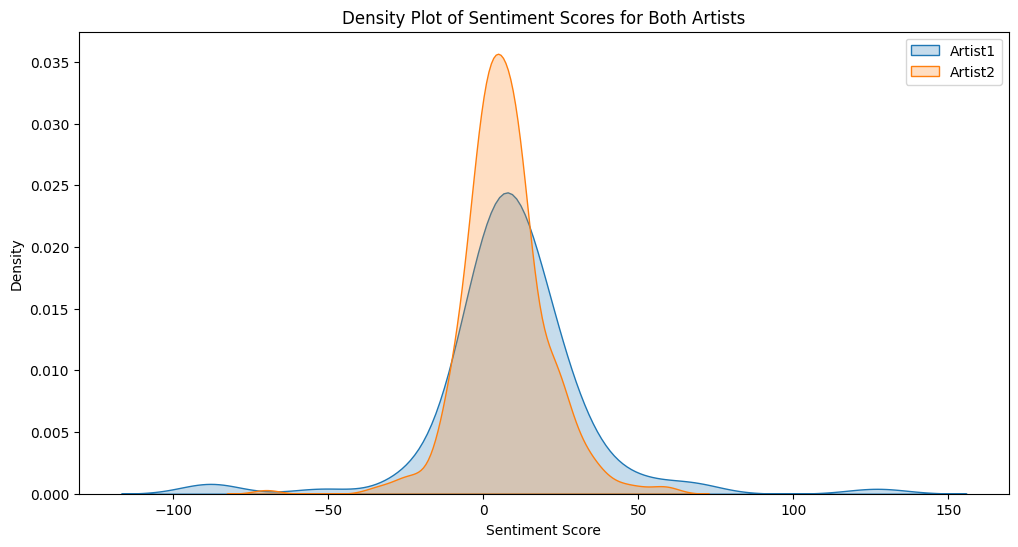

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of sentiment scores for both artists using seaborn
plt.figure(figsize=(12, 6))

# Density plot for Artist1
sns.kdeplot(data=lyrics_data[lyrics_data['artist'] == 'robyn'], x='sentiment_score', label='Artist1', shade=True)

# Density plot for Artist2
sns.kdeplot(data=lyrics_data[lyrics_data['artist'] == 'cher'], x='sentiment_score', label='Artist2', shade=True)

plt.title('Density Plot of Sentiment Scores for Both Artists')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()


## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [18]:
twitter_data

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher
...,...,...,...,...,...,...,...,...
358367,jakegiles,Jake Giles,19725102,LA,7690,2165,"singer of songs, type 1 diabetic, tired $jakel...",robyn
358368,axelbluhme,Axel Bluhme,19573759,DK,238,1565,Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...,robyn
358369,RayRayRay27,Rachael :),19919217,Oldham,762,1479,A year to change a life is still a year ✨😌,robyn
358370,bhandberg,Ben Handberg,12642462,Sydney,432,593,Head of Consumer - Mango. Made in Melbourne. R...,robyn


In [23]:
tw_punct = set(string.punctuation)
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens):
    stopwords_list = set(stopwords.words('english'))
    tokens_lower = [token.lower() for token in tokens]
    tokens_no_stopwords = [token for token in tokens_lower if token not in stopwords_list]
    # modify this function to remove stopwords
    return(tokens_no_stopwords)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    tokenized_words = word_tokenize(text)
    # modify this function to return tokens
    return(tokenized_words)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

In [24]:
# Apply the function to each element in the 'description' column
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]
twitter_data['cleaned_description'] = twitter_data['description'].apply(prepare,pipeline=my_pipeline)

In [26]:
twitter_data['sentiment_score'] = twitter_data['cleaned_description'].apply(lambda tokens: calculate_sentiment(tokens, lexicon))

In [27]:
positive_twitter_posts = twitter_data[twitter_data['sentiment_score'] > 0]
print("Positive Posts:")
positive_twitter_posts.head()

Positive Posts:


,screen_name,name,id,location,followers_count,friends_count,description,artist,cleaned_description,sentiment_score
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher,"[writer, washinformer, spelmancollege, alumna,...",3
9,macryant900,SpyderRyder,3425156986,🇨🇦,628,794,Let the healing begin. Let us learn from the p...,cher,"[let, healing, begin, let, us, learn, past, 🇨🇦...",2
17,Taliaasaurus,Σκουπίδια,332397786,NaN,134,314,(She/Her/Hers) Feminist. LGBTQ+. BLM. Mental h...,cher,"[sheherhers, feminist, lgbtq, blm, mental, hea...",2
21,Giselle99831932,Giselle,1349049200105955329,NaN,0,30,BLM I LOVE 80'S VIVA MÉXICO,cher,"[blm, love, 80s, viva, méxico]",1
23,JesseMFJones,Jesse Jones,3406666818,"Fort McMurray, Alberta",39,201,"I'm just a guy, married, kids and constantly w...",cher,"[im, guy, married, kids, constantly, wonder, h...",2


In [28]:
# Which artist has more negative songs?
negative_twitter_posts = twitter_data[twitter_data['sentiment_score'] < 0]
print("Negative songs:")
negative_twitter_posts.head()

Negative songs:


,screen_name,name,id,location,followers_count,friends_count,description,artist,cleaned_description,sentiment_score
6,Rodhandyjj,Art Vandalay 🇺🇦🇺🇦🇺🇦,1386454132022824962,"Maine, USA",104,159,I’m unemployed and live with my parents. MOOPS!,cher,"[’, unemployed, live, parents, moops]",-1
10,notdevilanse,Amanda 😇,916870029123211264,NaN,13,110,do what thou wilt. 🖤✨,cher,"[thou, wilt, 🖤✨]",-1
38,AdamTheeStan,CrackHeadBarbie,1363710785663488001,NaN,10,37,He/Him | 🏳️‍🌈 | AvaLance worshipper | Legends ...,cher,"[hehim, 🏳️‍🌈, avalance, worshipper, legends, w...",-1
39,bafwinn,A F 🔥,977945404921733121,NaN,31,197,BULLSHIT AF🔥,cher,"[bullshit, af🔥]",-1
69,DanAlme66710296,Don Menard,1144063909873061889,NaN,88,677,Boxing Fanatic. Sci Fi and Horror guy.,cher,"[boxing, fanatic, sci, fi, horror, guy]",-2


In [29]:
average_sentiment_per_artist_tw = twitter_data.groupby('artist')['sentiment_score'].mean()
# Print the average sentiment per artist
print("Average sentiment per artist twitter:")
print(average_sentiment_per_artist_tw)

# Determine which artist has the higher average sentiment
highest_average_sentiment_artist_tw = average_sentiment_per_artist_tw.idxmax()
print(f"The artist with the highest average sentiment per post is: {highest_average_sentiment_artist_tw}")

Average sentiment per artist twitter:
artist
cher     0.411400
robyn    0.354818
Name: sentiment_score, dtype: float64
The artist with the highest average sentiment per post is: cher


In [34]:
# Function to extract emojis
def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

# Function to count emoji frequency
def count_emojis(emoji_list):
    return pd.Series(emoji_list).value_counts()

# Extract emojis from cleaned_text
positive_twitter_posts['emojis'] = positive_twitter_posts['cleaned_description'].apply(extract_emojis)
negative_twitter_posts['emojis'] = negative_twitter_posts['cleaned_description'].apply(extract_emojis)

# Combine all emojis into a single list for counting
positive_emojis_list = positive_twitter_posts['emojis'].sum()
negative_emojis_list = negative_twitter_posts['emojis'].sum()

# Count emoji frequencies
positive_emoji_counts = count_emojis(positive_emojis_list)
negative_emoji_counts = count_emojis(negative_emojis_list)

# Get the most popular emojis
most_popular_positive_emoji = positive_emoji_counts.idxmax() if not positive_emoji_counts.empty else None
most_popular_negative_emoji = negative_emoji_counts.idxmax() if not negative_emoji_counts.empty else None

print("Most popular emoji in positive posts:")
print(most_popular_positive_emoji)

print("Most popular emoji in negative posts:")
print(most_popular_negative_emoji)

/var/folders/0n/bwyv05nn3hl95hhlm7qy85fh0000gn/T/ipykernel_93694/4048123817.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_twitter_posts['emojis'] = positive_twitter_posts['cleaned_description'].apply(extract_emojis)
/var/folders/0n/bwyv05nn3hl95hhlm7qy85fh0000gn/T/ipykernel_93694/4048123817.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_twitter_posts['emojis'] = negative_twitter_posts['cleaned_description'].apply(extract_emojis)


Most popular emoji in positive posts:
❤️
Most popular emoji in negative posts:
🏳️‍🌈


Q: What is the average sentiment of your two artists? 

A: Cher

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: Well, for the most popular positive emoji, we have a heart, which makes sense since a heart usually stands for something positive or has a positive context. But for the negative emoji, it appears that the rainbow flag is the most frequent. This could indicate a prevalence of negative posts related to the LGBTQ+ community. There might have been many negative posts from the LGBTQ+ community about these artists or some instances of discrimination. It is also possible that these are just sad posts from this community. It's interesting to see this show up as I did not expect to see that there.

